In [8]:
# optimizer with scaling and lin reg

import pandas as pd
import warnings
import gurobipy as gp
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr
from sklearn.neural_network import MLPRegressor

df = pd.read_csv('csv_dateien/starcraftFinalcsvs/stackedRunSup.csv')

# df = df[:1350]

dfTerranReg = df[df["fraction"] == "Terraner"]
dfTerranReg = df[df["supply"] > 0]

X = dfTerranReg[["total_workers", "supply"]]
y = dfTerranReg["resource_mining"]

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

scaler = StandardScaler()
lin_reg = make_pipeline(scaler, LinearRegression())
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
print(f"The R^2 value in the test set is {r2_score(y_test, y_pred)}")

data = pd.read_csv('csv_dateien/starcraftFinalcsvs/stackedRunSup.csv')
# data = data[1350:]

dfTerran = data[data["fraction"] == "Terraner"]


# ,player,total_workers,total_army_value,total_army,fraction,winner,replay_filename
dfTerran = dfTerran.drop(columns=[
                               "total_workers", "player", "replay_filename", "winner", "fraction", "Unnamed: 0", "total_army_value", "time", "total_army"])



# create variables
# create Model

m = gp.Model("Worker optimizer")
gppd.set_interactive()

w = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="total_workers", vtype=gp.GRB.INTEGER)
r_ges = gppd.add_vars(m, pandas_obj=dfTerran,
                      name="resource_mining")
a = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="total_army", vtype=gp.GRB.INTEGER)
s = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="supply", vtype=gp.GRB.INTEGER)

m.update()
dfTerran = dfTerran.drop(columns=["resource_mining"])
dfTerran

feats = dfTerran
feats = pd.concat([w, feats], axis=1)
print("------------------------------------------------------->")
print(feats.head)

m.setObjective(a.sum(), gp.GRB.MAXIMIZE) # Zielfunktion
gppd.add_constrs(m, ((r_ges - 50*w)/100), gp.GRB.GREATER_EQUAL, a) # Gleichung 2
gppd.add_constrs(m, w + a, gp.GRB.GREATER_EQUAL, 0) # Gleichung 3
gppd.add_constrs(m, w + a, gp.GRB.LESS_EQUAL, s) # Gleichung 4
m.update()

pred_constr = add_predictor_constr(m, lin_reg, feats, r_ges) # Einfügen des Regressiosmodells
pred_constr.print_stats()
m.optimize()
outputs = pred_constr.input_values
print(pred_constr.input_values)



The R^2 value in the test set is 0.7228663598692977
------------------------------------------------------->
<bound method NDFrame.head of                          total_workers  supply
4        <gurobi.Var total_workers[4]>    86.0
7        <gurobi.Var total_workers[7]>   157.0
8        <gurobi.Var total_workers[8]>   173.0
14      <gurobi.Var total_workers[14]>   188.0
16      <gurobi.Var total_workers[16]>    31.0
...                                ...     ...
1652  <gurobi.Var total_workers[1652]>   110.0
1656  <gurobi.Var total_workers[1656]>   133.0
1657  <gurobi.Var total_workers[1657]>   117.0
1662  <gurobi.Var total_workers[1662]>    39.0
1664  <gurobi.Var total_workers[1664]>    70.0

[416 rows x 2 columns]>
Model for pipe1:
1248 variables
1248 constraints
Input has shape (416, 2)
Output has shape (416, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints 

GurobiError: Unable to retrieve attribute 'X'

In [5]:
# optimizer with scaling and mlp regressor

import pandas as pd
import warnings
import gurobipy as gp
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr
from sklearn.neural_network import MLPRegressor

df = pd.read_csv('csv_dateien/starcraftFinalcsvs/stackedRunSup.csv')

df = df[:1350]

dfTerranReg = df[df["fraction"] == "Terraner"]
dfTerranReg = dfTerranReg[dfTerranReg["supply"] > 0]
X = dfTerranReg[["total_workers", "supply"]]
y = dfTerranReg["resource_mining"]


# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

feat_transform = make_column_transformer(
    (StandardScaler(), ["total_workers", "supply"]),
)

scaler = StandardScaler()
lin_reg = make_pipeline(feat_transform, MLPRegressor(random_state=1, max_iter=15000, learning_rate="adaptive"))
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
print(f"The R^2 value in the test set is {r2_score(y_test, y_pred)}")


data = pd.read_csv('csv_dateien/starcraftFinalcsvs/stackedRunSup.csv')
data = data[1350:]

dfTerran = data[data["fraction"] == "Terraner"]
dfTerranReg = dfTerranReg[dfTerranReg["supply"] > 0]


# ,player,total_workers,total_army_value,total_army,fraction,winner,replay_filename
dfTerran = dfTerran.drop(columns=[
                               "total_workers", "player", "replay_filename", "winner", "fraction", "Unnamed: 0", "total_army_value", "time", "total_army"])



# create variables
# create Model

m = gp.Model("Worker optimizer")
gppd.set_interactive()

w = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="total_workers", vtype=gp.GRB.INTEGER)
r_ges = gppd.add_vars(m, pandas_obj=dfTerran,
                      name="resource_mining")
a = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="total_army", vtype=gp.GRB.INTEGER)
s = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="supply", vtype=gp.GRB.INTEGER)

m.update()
dfTerran = dfTerran.drop(columns=["resource_mining"])

feats = dfTerran
feats = pd.concat([w, feats], axis=1)


m.setObjective(a.sum(), gp.GRB.MAXIMIZE) # Zielfunktion
gppd.add_constrs(m, ((r_ges - 50*w)/100), gp.GRB.GREATER_EQUAL, a) # Gleichung 2
gppd.add_constrs(m, w + a, gp.GRB.GREATER_EQUAL, 0) # Gleichung 3
gppd.add_constrs(m, w + a, gp.GRB.LESS_EQUAL, 200) # Gleichung 4
m.update()

pred_constr = add_predictor_constr(m, lin_reg, feats, r_ges) # Einfügen des Regressiosmodells
pred_constr.print_stats()
m.optimize()
outputs = pred_constr.input_values
outputs


c:\Users\nicol\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15000) reached and the optimization hasn't converged yet.
  warnings.warn(


The R^2 value in the test set is 0.6462250328373538
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Model for pipe1:
99673 variables
50573 constraints
49100 general constraints
Input has shape (491, 2)
Output has shape (491, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans1          (491, 2)         1473          982            0            0

dense1            (491, 100)        98200        49100            0        49100 (relu)

dense2              (491, 1)            0          491            0            0


--------------------------------------------------------------------------------
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|A

,total_workers,supply
1350,0,165
1354,0,204
1357,54,31
1358,56,23
1359,37,101
...,...,...
3311,33,110
3315,6,133
3316,25,117
3321,53,39


In [9]:

solution = pd.DataFrame()

solution["total_workers"] = w.gppd.X
solution["supply"] = dfTerran["supply"]

solution


,total_workers,supply
1350,0.0,165.0
1354,0.0,204.0
1357,54.0,31.0
1358,56.0,23.0
1359,37.0,101.0
...,...,...
3311,33.0,110.0
3315,6.0,133.0
3316,25.0,117.0
3321,53.0,39.0


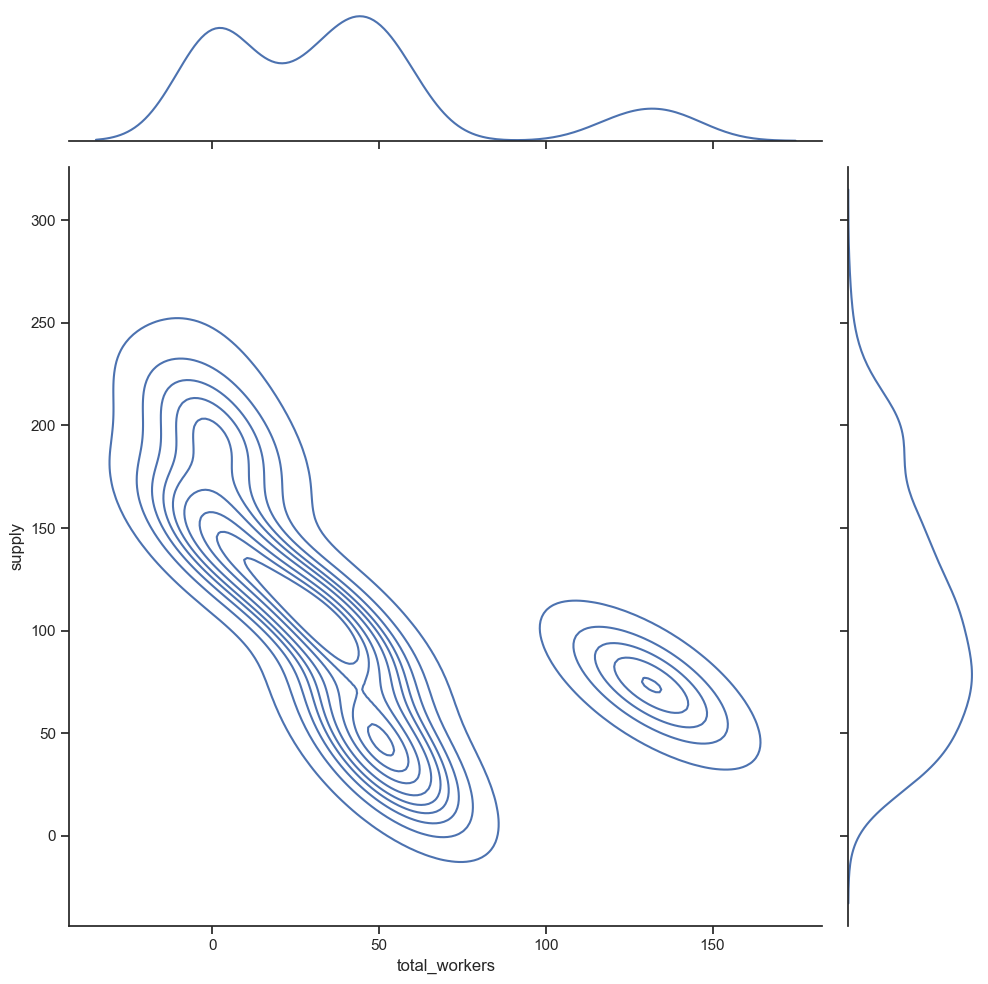

In [10]:
custom_palette = ["#dd8452","#4c72b0",  "#55a868"]
sns.set_theme(style="ticks")
# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=solution, palette=custom_palette,
    x="total_workers", y="supply",  # ylim=[None, 150],
    kind="kde", height=10
)